In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

DATA_DIR = Path(
    "/home/christian/Documents/research/MIST/mistsim/examples/data/20260215_for_christian"
)

## Raul's simulation

In [2]:
import h5py


def read_hdf5_convolution(path_file, print_key=False):
    with h5py.File(path_file, "r") as hf:
        if print_key:
            print([key for key in hf.keys()])

        hfX = hf.get("lst")
        lst = np.array(hfX)
        hfX = hf.get("freq")
        freq = np.array(hfX)
        hfX = hf.get("ant_temp")
        ant_temp = np.array(hfX)

    return lst, freq, ant_temp

path = Path(DATA_DIR) / Path("antenna_temperature_20260215_test1.hdf5")
lst, freqs, ant_temp_r = read_hdf5_convolution(path, print_key=True)

['ant_temp', 'freq', 'lst']


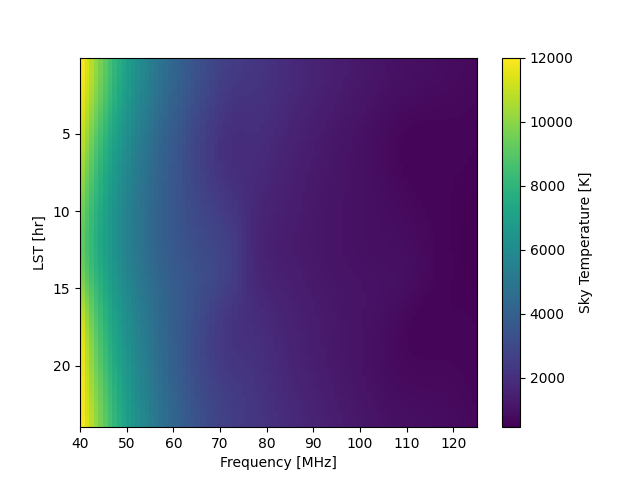

In [3]:
def waterfall(ant_temp, cmap="viridis", vmin=None, vmax=None):
    extent = [freqs[0], freqs[-1], lst[-1], lst[0]]
    fig = plt.figure()
    ax = plt.gca()
    im = ax.imshow(
        ant_temp,
        interpolation="none",
        aspect="auto",
        extent=extent,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
    )
    fig.colorbar(im, label="Sky Temperature [K]")
    ax.set_xlabel("Frequency [MHz]")
    ax.set_ylabel("LST [hr]")
    return fig, ax

fig, ax = waterfall(ant_temp_r, vmin=450, vmax=12000)

## MISTSIM

In [4]:
import jax
import jax.numpy as jnp

jax.config.update('jax_enable_x64', True)

In [5]:
from functools import partial

import astropy.units as u
import croissant.jax as crojax
import healpy as hp
import s2fft
from astropy.coordinates import EarthLocation
from astropy.io import fits
from astropy.time import Time

import mistsim as ms

The croissant.jax interface is deprecated and will be removed in a future release. Please use the croissant interface directly instead.


In [6]:
# force jupyter to always show FutureWarnings
import warnings

warnings.simplefilter("always", FutureWarning)

In [7]:
NSIDE = 128
SIM_LMAX = 100

## Sky model

In [8]:
def load_haslam(fname="haslam408_ds_Remazeilles2014.fits"):
    fpath = DATA_DIR / Path(fname)
    with fits.open(fpath) as hdul:
        hdul.info()
        data = hdul[1].data
        header = hdul[1].header
    return data, header

def scale_map(m, freqs, beta=-2.55, f0=408, tcmb=2.725):
    scale = (freqs/f0)**beta
    return (m-tcmb)[None, :] * scale[:, None] + tcmb

In [9]:
data, hdr = load_haslam()
print(hdr)

Filename: /home/christian/Documents/research/MIST/mistsim/examples/data/20260215_for_christian/haslam408_ds_Remazeilles2014.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1                1 BinTableHDU     42   3072R x 1C   [1024E]   
XTENSION= 'BINTABLE'           /Written by IDL:  Mon Nov 17 15:44:43 2014       BITPIX  =                    8 /                                                NAXIS   =                    2 /Binary table                                    NAXIS1  =                 4096 /Number of bytes per row                         NAXIS2  =                 3072 /Number of rows                                  PCOUNT  =                    0 /Random parameter count                          GCOUNT  =                    1 /Group count                                     TFIELDS =                    1 /Number of columns                               TFORM1  = '1024E   '           /Real*4 (floating poi

In [10]:
# map is in galactic, nside=512, ordring=ring
haslam = data["TEMPERATURE"].ravel()
haslam = hp.ud_grade(haslam, NSIDE, order_in="RING")
ga2eq = hp.Rotator(coord="gc")
haslam_eq = ga2eq.rotate_map_alms(haslam)

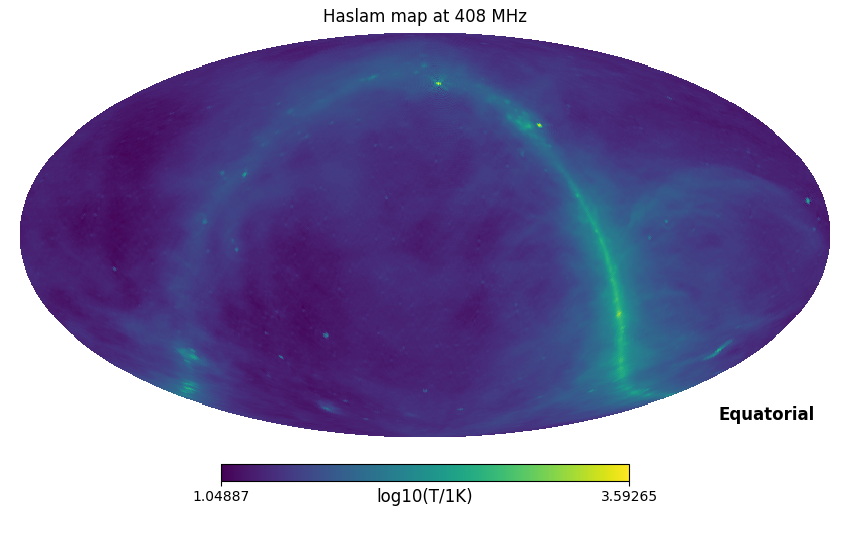

In [11]:
hp.mollview(
    np.log10(haslam_eq),
    coord="C",
    title="Haslam map at 408 MHz",
    cbar=True,
    unit="log10(T/1K)",
)
plt.show()

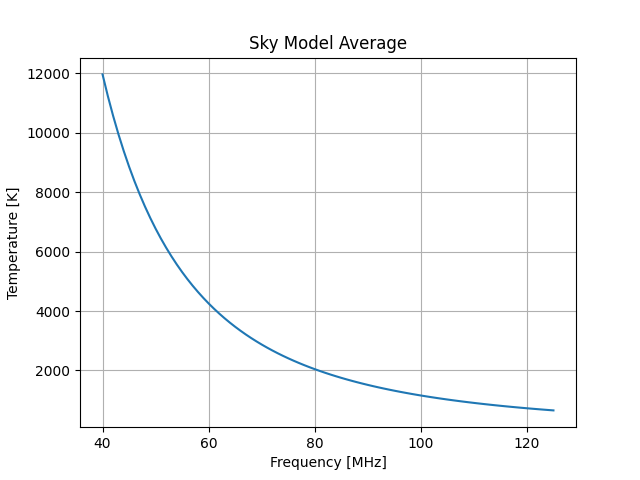

In [12]:
sky_model = scale_map(haslam_eq, freqs)

plt.figure()
plt.plot(freqs, sky_model.mean(axis=1))
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [K]")
plt.title("Sky Model Average")
plt.grid()
plt.show()

In [13]:
sky_L = 2 * NSIDE
sky2alm = partial(
    s2fft.forward,
    L=sky_L,
    spin=0,
    nside=NSIDE,
    sampling="healpix",
    method="jax_healpy",
    reality=True,
)

# no vmap support for jax_healpy
sky_alm = jnp.array([sky2alm(m) for m in sky_model])

# reduce lmax
sky_alm = crojax.alm.reduce_lmax(sky_alm, SIM_LMAX)
print(sky_alm.shape)

(86, 101, 201)


## Beam model

In [14]:
def load_beam(fname="beam.npz"):
    d = np.load(DATA_DIR / Path(fname))
    freqs = d["freqs"]
    phi = d["phi"]
    theta = d["theta"]
    gain = d["gain"]
    return freqs, phi, theta, gain

freqs_beam, phi, theta, gain_above = load_beam()

print(freqs_beam/1e6)
print(phi)
print(theta)
print(gain_above.shape)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.

Frequencies match: True
(86, 181, 360)


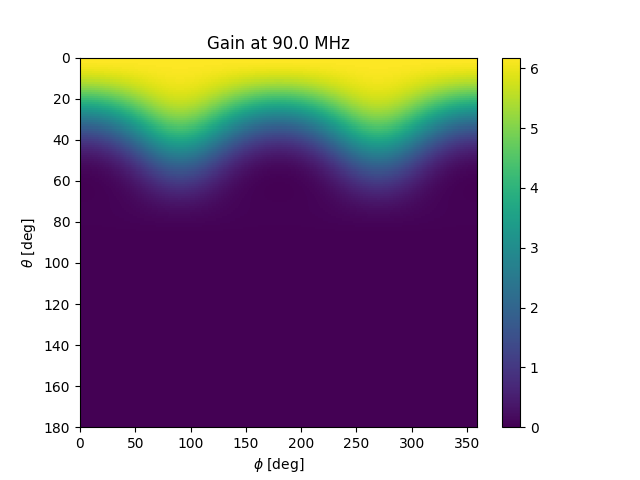

In [15]:
# need to restrict to same freq range as sky
fix = np.isin(freqs_beam/1e6, freqs)
gain_above = gain_above[fix]
freqs_beam = freqs_beam[fix]
print(f"Frequencies match: {np.allclose(freqs_beam/1e6, freqs)}")

# theta needs to go 0 to 180
gain_below = np.zeros_like(gain_above[:, :-1, :])
gain = np.concatenate((gain_above, gain_below), axis=1)
print(gain.shape)

theta = np.concatenate((theta, np.arange(91, 181)))


plt.figure()
plt.imshow(
    gain[50], aspect="auto", interpolation="none", extent=[0, 359, 180, 0]
)
plt.colorbar()
plt.title(f"Gain at {freqs[50]} MHz")
plt.xlabel("$\\phi$ [deg]")
plt.ylabel("$\\theta$ [deg]")
plt.show()

In [16]:
horizon = theta <= 80
horizon = horizon[:, None]
beam = ms.Beam(gain, freqs, horizon=horizon, lmax=SIM_LMAX)

/tmp/ipykernel_113648/2888939281.py:3: FutureWarning: Lmax is now automatically determined from the data shape  and the sampling scheme and will be ignored if provided. In the future, this will become an error.
  beam = ms.Beam(gain, freqs, horizon=horizon, lmax=SIM_LMAX)


## Simulator

In [17]:
# define observation time and location, 0 to 24 hrs, 6 min bins
lon = -90.74750
lat = 79.41833
alt = 150
loc = EarthLocation.from_geodetic(lon, lat, height=alt)

t0 = Time("2022-07-17 00:00", location=loc)

def lst_to_time(lst_arr, t0=t0):
    """
    Convert array of LST to array of astropy Time objects
    for use with croissant

    Parameters
    ----------
    lst_arr : array_like
        List of LST in hrs
    t0 : Time
        Reference time.
    """
    lst_ref = t0.sidereal_time("mean").hour
    delta = (lst_arr - lst_ref) /24 * u.sday
    times = t0 + delta
    return times

times = lst_to_time(lst)
print(f"LST match: {np.allclose(times.sidereal_time('mean').hour, lst)}")

LST match: True


In [18]:
sim = ms.Simulator(beam, sky_alm, times.jd, freqs, lon, lat, alt=alt, Tgnd=0)

/tmp/ipykernel_113648/1079391449.py:1: FutureWarning: Providing sky as an alm instead of a Sky object isdeprecated and will be removed in a future version. Please switch to using a Sky object for the sky model.
  sim = ms.Simulator(beam, sky_alm, times.jd, freqs, lon, lat, alt=alt, Tgnd=0)


In [19]:
tant = sim.sim()
fgnd = sim.beam.compute_fgnd()
tsky = ms.sim.correct_ground_loss(tant, fgnd, sim.Tgnd)

/tmp/ipykernel_113648/51243187.py:3: FutureWarning: The `correct_ground_loss` function in sim.py is deprecated and will be removed in a future version. Please use the `correct_ground_loss` function in croissant.simulator instead.
  tsky = ms.sim.correct_ground_loss(tant, fgnd, sim.Tgnd)


In [20]:
fig, ax = waterfall(tsky, vmin=450, vmax=12000)

## Compare Raul's sim with MISTSIM

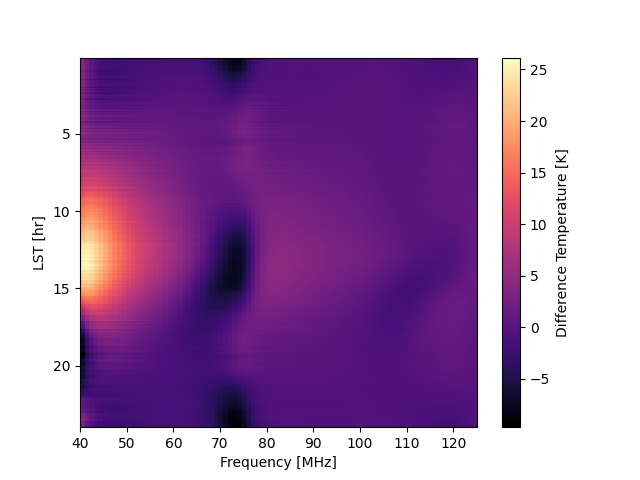

In [21]:
# ant_temp_r = raul's sim, tsky = mistsim
diff = ant_temp_r - tsky

fig, ax = waterfall(diff, cmap="magma")
im = ax.images[-1]
im.colorbar.set_label("Difference Temperature [K]")